# Consulta de datos a la NASA

In [36]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import numpy as np
import empiricaldist
import os
from io import StringIO
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import IsolationForest
pd.set_option('display.float_format', '{:.2f}'.format)

In [37]:
API_URL = "https://power.larc.nasa.gov/api/temporal/hourly/point"
latitud = 31.3
longitud = -113.51

API_parametros = "ALLSKY_SFC_SW_DWN,ALLSKY_SFC_SW_DNI,ALLSKY_SFC_SW_DIFF,ALLSKY_KT"
API_ce = "RE" 

inicio = 2001
final = 2025 

directorio_de_salida = '/mnt/c/Users/LENOVO/Documents/Portafolio/Datos'
nombre_del_archivo = "irradiancia_nasa_bruta_2010_2025.xlsx" 
path_completo = os.path.join(directorio_de_salida, nombre_del_archivo)
os.makedirs(directorio_de_salida, exist_ok=True)


df_juntos = [] 
errores_fecha = []

print("📡 Iniciando consulta...")


for fecha in range(inicio, final + 1): 
    
    params = {
        "parameters": API_parametros,
        "community": API_ce,
        "start": f"{fecha}0101",
        "end": f"{fecha}1231",
        "latitude": latitud,
        "longitude": longitud,
        "format": "CSV",
        "time-standard": "UTC"
    }

    try:
        respuesta = requests.get(API_URL, params=params)
        respuesta.raise_for_status() 
        lineas = respuesta.text.splitlines()
        
        indice_inicio = -1
        for i, linea in enumerate(lineas):
            if linea.strip().startswith("YEAR,"):
                indice_inicio = i
                break
        
        if indice_inicio == -1:
            raise ValueError("No se encontró el encabezado de datos (YEAR,...) en la respuesta CSV.")

        condenido_csv = "\n".join(lineas[indice_inicio:])
        df_fecha_corriente = pd.read_csv(StringIO(condenido_csv))

        df_fecha_corriente = df_fecha_corriente.rename(columns={
             "ALLSKY_SFC_SW_DWN": "Irradiancia_Global_Horizontal",
             "ALLSKY_SFC_SW_DNI": "Irradiancia_Directa_Normal",
             "ALLSKY_SFC_SW_DIFF": "Irradiancia_Difusa_Horizontal",
             "ALLSKY_KT": "Indice_Claridad"
         })

        
        df_fecha_corriente["DATETIME_UTC"] = pd.to_datetime(
            df_fecha_corriente["YEAR"].astype(str) +
            df_fecha_corriente["MO"].astype(str).str.zfill(2) +
            df_fecha_corriente["DY"].astype(str).str.zfill(2) +
            df_fecha_corriente["HR"].astype(str).str.zfill(2),
            format="%Y%m%d%H",
            utc=True # Indica que la hora es UTC
        ) 
        df_fecha_corriente["DATETIME_LOCAL"] = df_fecha_corriente["DATETIME_UTC"].dt.tz_convert("America/Mexico_City") 
        
        df_fecha_corriente["DATETIME_UTC"] = df_fecha_corriente["DATETIME_UTC"].dt.tz_localize(None)
        df_fecha_corriente["DATETIME_LOCAL"] = df_fecha_corriente["DATETIME_LOCAL"].dt.tz_localize(None)    
        df_juntos.append(df_fecha_corriente)
        print(f"✅ Año {fecha} consultado y procesado.")

    except requests.exceptions.HTTPError as http_err:
        print(f"❌ Error HTTP al consultar el año {fecha}: {http_err}. URL: {respuesta.url}")
        errores_fecha.append(fecha)
    except requests.exceptions.ConnectionError as conn_err:
        print(f"❌ Error de conexión al consultar el año {fecha}: {conn_err}. Verifica tu internet.")
        errores_fecha.append(fecha)
    except ValueError as val_err:
        print(f"❌ Error de datos/formato CSV para el año {fecha}: {val_err}")
        errores_fecha.append(fecha)
    except Exception as e:
        print(f"❌ Error inesperado al procesar el año {fecha}: {e}")
        errores_fecha.append(fecha)


if df_juntos:
    df_final = pd.concat(df_juntos, ignore_index=True)
       
    df_final["FECHA_HORA_LOCAL"] = df_final["DATETIME_LOCAL"]

    print(f"\n📁 Archivo guardado: {path_completo}")
    try:
        df_final.to_excel(path_completo, index=False)
        
    except PermissionError:
        print(f"\n❌ ERROR: No se pudo guardar el archivo '{path_completo}'.")
        print("❗ Causa probable: El archivo Excel está abierto. Ciérralo y vuelve a ejecutar.")
    except Exception as e:
        print(f"\n❌ Ocurrió un error inesperado al guardar el archivo: {e}")
else:
    print("⚠️ No se pudieron consultar datos para ningún año. No se generará archivo Excel.")


if errores_fecha:
    print(f"\n⚠️ Años con errores o no consultados: {errores_fecha}")
else:
    print("\n✅ Todos los años fueron consultados exitosamente.")


📡 Iniciando consulta...
✅ Año 2001 consultado y procesado.
✅ Año 2002 consultado y procesado.
✅ Año 2003 consultado y procesado.
✅ Año 2004 consultado y procesado.
✅ Año 2005 consultado y procesado.
✅ Año 2006 consultado y procesado.
✅ Año 2007 consultado y procesado.
✅ Año 2008 consultado y procesado.
✅ Año 2009 consultado y procesado.
✅ Año 2010 consultado y procesado.
✅ Año 2011 consultado y procesado.
✅ Año 2012 consultado y procesado.
✅ Año 2013 consultado y procesado.
✅ Año 2014 consultado y procesado.
✅ Año 2015 consultado y procesado.
✅ Año 2016 consultado y procesado.
✅ Año 2017 consultado y procesado.
✅ Año 2018 consultado y procesado.
✅ Año 2019 consultado y procesado.
✅ Año 2020 consultado y procesado.
✅ Año 2021 consultado y procesado.
✅ Año 2022 consultado y procesado.
✅ Año 2023 consultado y procesado.
✅ Año 2024 consultado y procesado.
✅ Año 2025 consultado y procesado.

📁 Archivo guardado: /mnt/c/Users/LENOVO/Documents/Portafolio/Datos/irradiancia_nasa_bruta_2010_2025.

# Primer filtrado de datos

In [38]:
columnas_eliminar = ['YEAR', 'MO', 'DY', 'HR', 'DATETIME_LOCAL']
df_datos = df_final.drop(columns=columnas_eliminar).copy()
df_datos

,Irradiancia_Global_Horizontal,Irradiancia_Directa_Normal,Irradiancia_Difusa_Horizontal,Indice_Claridad,DATETIME_UTC,FECHA_HORA_LOCAL
0,13.93,27.87,16.32,0.27,2001-01-01 00:00:00,2000-12-31 18:00:00
1,0.00,0.00,0.00,-999.00,2001-01-01 01:00:00,2000-12-31 19:00:00
2,0.00,0.00,0.00,-999.00,2001-01-01 02:00:00,2000-12-31 20:00:00
3,0.00,0.00,0.00,-999.00,2001-01-01 03:00:00,2000-12-31 21:00:00
4,0.00,0.00,0.00,-999.00,2001-01-01 04:00:00,2000-12-31 22:00:00
...,...,...,...,...,...,...
214963,-999.00,-999.00,-999.00,-999.00,2025-07-10 19:00:00,2025-07-10 13:00:00
214964,-999.00,-999.00,-999.00,-999.00,2025-07-10 20:00:00,2025-07-10 14:00:00
214965,-999.00,-999.00,-999.00,-999.00,2025-07-10 21:00:00,2025-07-10 15:00:00
214966,-999.00,-999.00,-999.00,-999.00,2025-07-10 22:00:00,2025-07-10 16:00:00


In [39]:
columnas = ['Irradiancia_Global_Horizontal', 'Irradiancia_Directa_Normal', 'Irradiancia_Difusa_Horizontal']

df_mascara_cero = (df_datos[columnas] == 0).all(axis = 1)
df_analisis_1 = df_datos[~df_mascara_cero].copy()
df_analisis_1

,Irradiancia_Global_Horizontal,Irradiancia_Directa_Normal,Irradiancia_Difusa_Horizontal,Indice_Claridad,DATETIME_UTC,FECHA_HORA_LOCAL
0,13.93,27.87,16.32,0.27,2001-01-01 00:00:00,2000-12-31 18:00:00
14,4.07,11.70,5.64,0.22,2001-01-01 14:00:00,2001-01-01 08:00:00
15,73.18,64.20,61.32,0.32,2001-01-01 15:00:00,2001-01-01 09:00:00
16,201.23,115.51,158.31,0.43,2001-01-01 16:00:00,2001-01-01 10:00:00
17,336.95,142.04,254.40,0.52,2001-01-01 17:00:00,2001-01-01 11:00:00
...,...,...,...,...,...,...
214963,-999.00,-999.00,-999.00,-999.00,2025-07-10 19:00:00,2025-07-10 13:00:00
214964,-999.00,-999.00,-999.00,-999.00,2025-07-10 20:00:00,2025-07-10 14:00:00
214965,-999.00,-999.00,-999.00,-999.00,2025-07-10 21:00:00,2025-07-10 15:00:00
214966,-999.00,-999.00,-999.00,-999.00,2025-07-10 22:00:00,2025-07-10 16:00:00


In [40]:
columnas_999 = ['Irradiancia_Global_Horizontal', 'Irradiancia_Directa_Normal', 'Irradiancia_Difusa_Horizontal', 'Indice_Claridad']
df_analisis_1[columnas_999] = df_analisis_1[columnas_999].replace(-999, np.nan)

# Primera validación de datos

In [41]:
df_analisis_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113736 entries, 0 to 214967
Data columns (total 6 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Irradiancia_Global_Horizontal  111312 non-null  float64       
 1   Irradiancia_Directa_Normal     111312 non-null  float64       
 2   Irradiancia_Difusa_Horizontal  111312 non-null  float64       
 3   Indice_Claridad                111312 non-null  float64       
 4   DATETIME_UTC                   113736 non-null  datetime64[ns]
 5   FECHA_HORA_LOCAL               113736 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(4)
memory usage: 6.1 MB


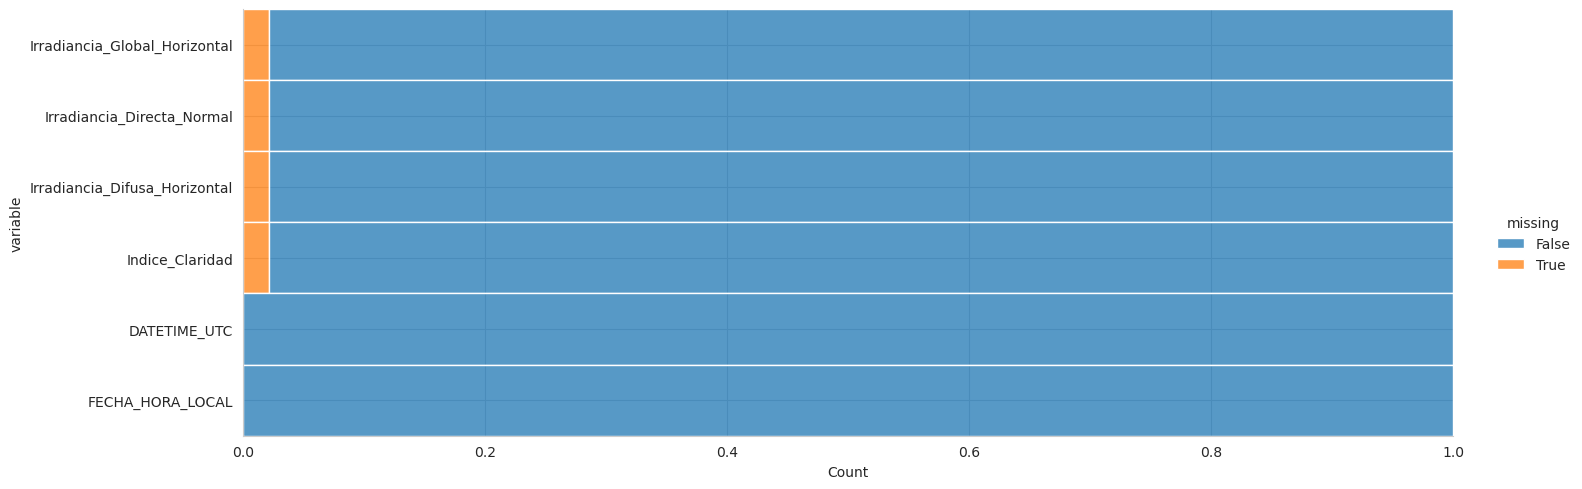

In [42]:
df_analisis_1.isnull().melt(value_name='missing').pipe(
                                                 lambda df_analisis_1: sns.displot(data=df_analisis_1, 
                                                 y='variable', 
                                                 hue= 'missing', 
                                                 multiple='fill',
                                                 aspect =3))

In [43]:
df_analisis_1.isnull().sum().sort_values(ascending = False)

Irradiancia_Global_Horizontal    2424
Irradiancia_Directa_Normal       2424
Irradiancia_Difusa_Horizontal    2424
Indice_Claridad                  2424
DATETIME_UTC                        0
FECHA_HORA_LOCAL                    0
dtype: int64

In [44]:
((df_analisis_1.isnull().sum()/df_analisis_1.shape[0]).sort_values(ascending=False))*100

Irradiancia_Global_Horizontal   2.13
Irradiancia_Directa_Normal      2.13
Irradiancia_Difusa_Horizontal   2.13
Indice_Claridad                 2.13
DATETIME_UTC                    0.00
FECHA_HORA_LOCAL                0.00
dtype: float64

In [45]:
indices_faltantes = df_analisis_1[df_analisis_1.isnull().any(axis=1)].index.tolist()

print(indices_faltantes)
print(len(indices_faltantes))

[212544, 212545, 212546, 212547, 212548, 212549, 212550, 212551, 212552, 212553, 212554, 212555, 212556, 212557, 212558, 212559, 212560, 212561, 212562, 212563, 212564, 212565, 212566, 212567, 212568, 212569, 212570, 212571, 212572, 212573, 212574, 212575, 212576, 212577, 212578, 212579, 212580, 212581, 212582, 212583, 212584, 212585, 212586, 212587, 212588, 212589, 212590, 212591, 212592, 212593, 212594, 212595, 212596, 212597, 212598, 212599, 212600, 212601, 212602, 212603, 212604, 212605, 212606, 212607, 212608, 212609, 212610, 212611, 212612, 212613, 212614, 212615, 212616, 212617, 212618, 212619, 212620, 212621, 212622, 212623, 212624, 212625, 212626, 212627, 212628, 212629, 212630, 212631, 212632, 212633, 212634, 212635, 212636, 212637, 212638, 212639, 212640, 212641, 212642, 212643, 212644, 212645, 212646, 212647, 212648, 212649, 212650, 212651, 212652, 212653, 212654, 212655, 212656, 212657, 212658, 212659, 212660, 212661, 212662, 212663, 212664, 212665, 212666, 212667, 212668,

# Segunda limpieza de datos

In [46]:
columnas_999 = ['Irradiancia_Global_Horizontal', 'Irradiancia_Directa_Normal', 'Irradiancia_Difusa_Horizontal', 'Indice_Claridad']
df_mascara_nan = df_analisis_1[columnas_999].isna().all(axis=1)
df_analisis_2 = df_analisis_1[~df_mascara_nan].copy()
df_analisis_2

,Irradiancia_Global_Horizontal,Irradiancia_Directa_Normal,Irradiancia_Difusa_Horizontal,Indice_Claridad,DATETIME_UTC,FECHA_HORA_LOCAL
0,13.93,27.87,16.32,0.27,2001-01-01 00:00:00,2000-12-31 18:00:00
14,4.07,11.70,5.64,0.22,2001-01-01 14:00:00,2001-01-01 08:00:00
15,73.18,64.20,61.32,0.32,2001-01-01 15:00:00,2001-01-01 09:00:00
16,201.23,115.51,158.31,0.43,2001-01-01 16:00:00,2001-01-01 10:00:00
17,336.95,142.04,254.40,0.52,2001-01-01 17:00:00,2001-01-01 11:00:00
...,...,...,...,...,...,...
212539,920.53,853.27,176.82,0.76,2025-03-31 19:00:00,2025-03-31 13:00:00
212540,831.47,844.00,218.16,0.70,2025-03-31 20:00:00,2025-03-31 14:00:00
212541,792.65,718.24,256.49,0.74,2025-03-31 21:00:00,2025-03-31 15:00:00
212542,621.42,637.13,226.54,0.69,2025-03-31 22:00:00,2025-03-31 16:00:00


In [47]:
df_analisis_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111312 entries, 0 to 212543
Data columns (total 6 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Irradiancia_Global_Horizontal  111312 non-null  float64       
 1   Irradiancia_Directa_Normal     111312 non-null  float64       
 2   Irradiancia_Difusa_Horizontal  111312 non-null  float64       
 3   Indice_Claridad                111312 non-null  float64       
 4   DATETIME_UTC                   111312 non-null  datetime64[ns]
 5   FECHA_HORA_LOCAL               111312 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(4)
memory usage: 5.9 MB


In [48]:
df_analisis_2.isnull().sum()

Irradiancia_Global_Horizontal    0
Irradiancia_Directa_Normal       0
Irradiancia_Difusa_Horizontal    0
Indice_Claridad                  0
DATETIME_UTC                     0
FECHA_HORA_LOCAL                 0
dtype: int64

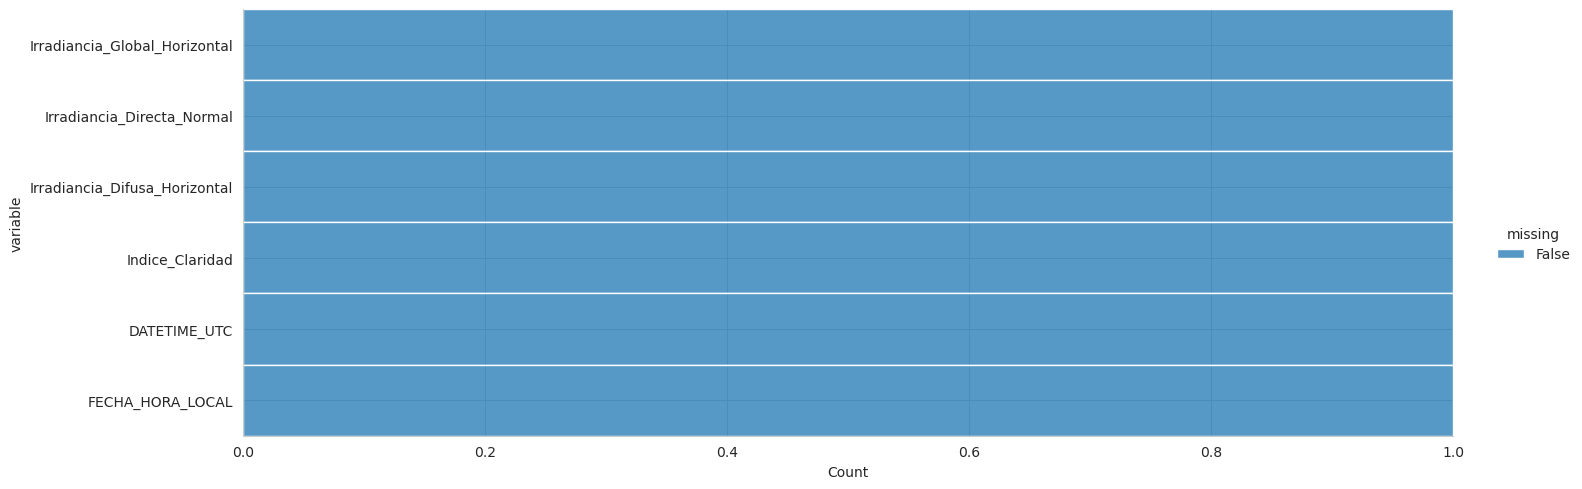

In [49]:
df_analisis_2.isnull().melt(value_name='missing').pipe(
                                                  lambda df_analisis_2: sns.displot(
                                                  data=df_analisis_2,
                                                  y='variable',
                                                  hue= 'missing',
                                                  multiple='fill',
                                                  aspect =3))

In [50]:
df_analisis_2.isnull().sum()/df_analisis_2.shape[0]

Irradiancia_Global_Horizontal   0.00
Irradiancia_Directa_Normal      0.00
Irradiancia_Difusa_Horizontal   0.00
Indice_Claridad                 0.00
DATETIME_UTC                    0.00
FECHA_HORA_LOCAL                0.00
dtype: float64

In [51]:
df_analisis_2.isnull().any()

Irradiancia_Global_Horizontal    False
Irradiancia_Directa_Normal       False
Irradiancia_Difusa_Horizontal    False
Indice_Claridad                  False
DATETIME_UTC                     False
FECHA_HORA_LOCAL                 False
dtype: bool

# Medidas de tendecia central

In [52]:
df_analisis_2.describe(include=np.number)

,Irradiancia_Global_Horizontal,Irradiancia_Directa_Normal,Irradiancia_Difusa_Horizontal,Indice_Claridad
count,111312.00,111312.00,111312.00,111312.00
mean,476.30,609.53,108.71,0.62
std,311.11,313.36,79.36,0.17
min,1.58,0.00,1.80,0.04
25%,183.98,369.92,59.31,0.52
50%,491.92,708.62,91.46,0.68
75%,738.00,866.77,137.77,0.75
max,1095.90,1216.93,628.35,0.85


# Medidas de dispersión

/tmp/ipykernel_66804/3459399754.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


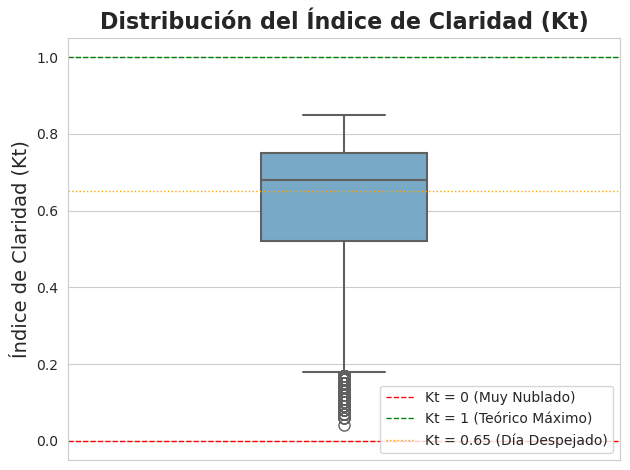

In [53]:
sns.boxplot(
    y=df_analisis_2['Indice_Claridad'], 
    palette='Blues',   
    width=0.3,        
    linewidth=1.5,
    fliersize=8,       
)

plt.title('Distribución del Índice de Claridad (Kt)', fontsize=16, fontweight='bold')
plt.ylabel('Índice de Claridad (Kt)', fontsize=14)
plt.xlabel('') 
plt.xticks([]) 

plt.axhline(y=0,
            color='red',
            linestyle='--',
            linewidth=1,
            label='Kt = 0 (Muy Nublado)')

plt.axhline(y=1,
            color='green',
            linestyle='--',
            linewidth=1,
            label='Kt = 1 (Teórico Máximo)')

plt.axhline(y=0.65,
            color='orange',
            linestyle=':',
            linewidth=1,
            label='Kt = 0.65 (Día Despejado)')

plt.legend(fontsize=10, loc='lower right') 

plt.tight_layout()
plt.show()


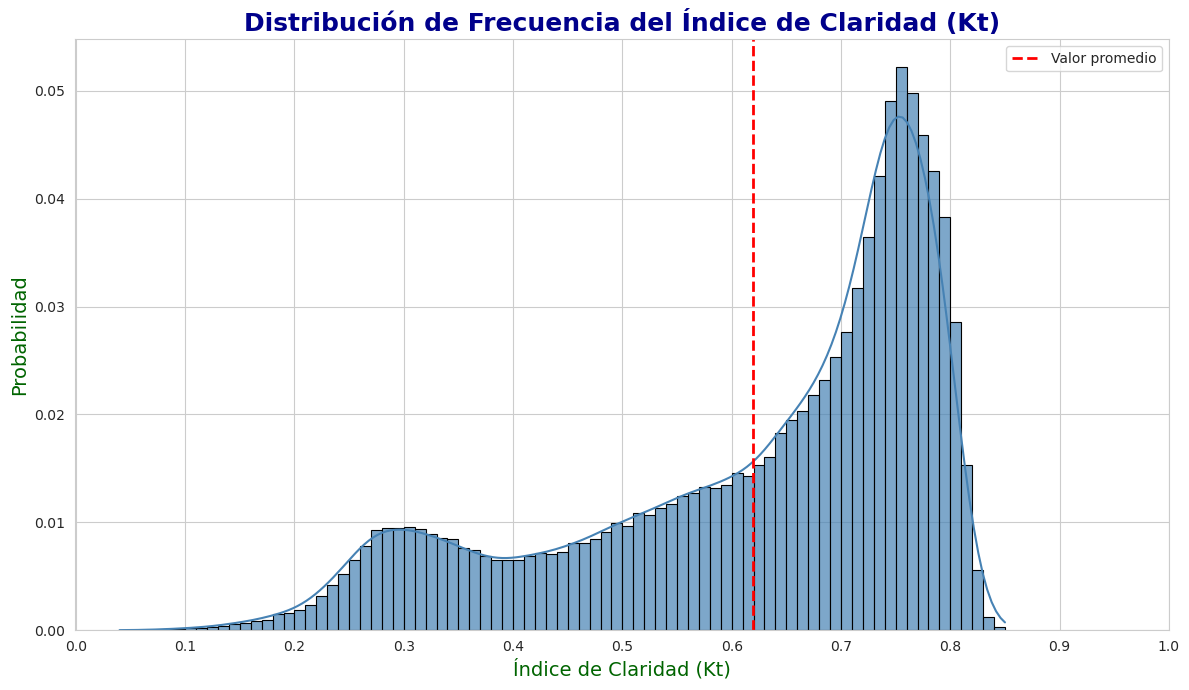

In [54]:
sns.set_style("whitegrid") 
plt.figure(figsize=(12, 7)) 


sns.histplot(
    data=df_analisis_2,
    x='Indice_Claridad',
    binwidth=0.01,          
    color='steelblue',      
    edgecolor='black',      
    linewidth=0.8,          
    alpha=0.7,              
    kde=True,               
    stat='probability',
)

plt.title('Distribución de Frecuencia del Índice de Claridad (Kt)',
          fontsize=18,
          fontweight='bold',
          color='darkblue')

plt.xlabel('Índice de Claridad (Kt)',
           fontsize=14,
           color='darkgreen')

plt.ylabel('Probabilidad', fontsize=14, color='darkgreen') 

plt.axvline(x=df_analisis_2.Indice_Claridad.mean(), 
            color = 'red',
            linestyle = 'dashed',
            linewidth = 2,
            label = 'Valor promedio')

plt.legend()

plt.xticks(np.arange(0, 1.01, 0.1), fontsize=10)

plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

/tmp/ipykernel_66804/3339555795.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


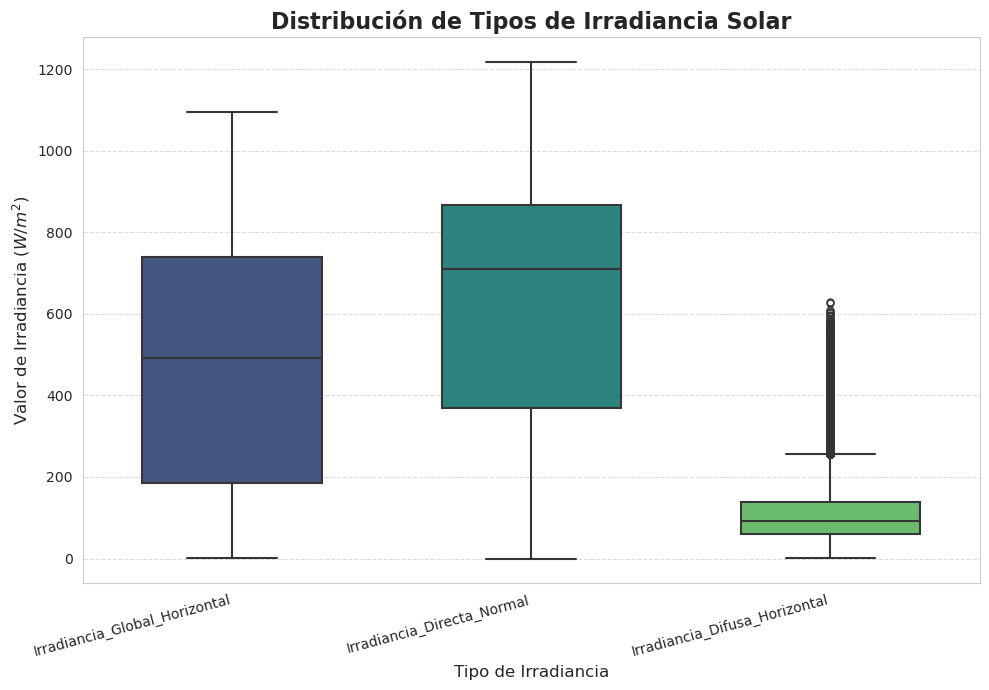

In [ ]:
columnas_derretir = ['Irradiancia_Global_Horizontal', 'Irradiancia_Directa_Normal',	'Irradiancia_Difusa_Horizontal']
df_derretido = pd.melt(df_analisis_2, 
                       id_vars = ['FECHA_HORA_LOCAL'], 
                       value_vars = columnas_derretir,
                       var_name = 'Tipo_Irradiancia',
                       value_name = 'Valor_Irradiancia' )

plt.figure(figsize=(10, 7)) 
sns.boxplot(
    data=df_derretido,
    x='Tipo_Irradiancia',
    y='Valor_Irradiancia',
    palette='viridis', 
    width=0.6,         
    linewidth=1.5,     
    fliersize=5,       
)

plt.title('Distribución de Tipos de Irradiancia Solar', fontsize=16, fontweight='bold')
plt.xlabel('Tipo de Irradiancia', fontsize=12)
plt.ylabel('Valor de Irradiancia ($W/m^2$)', fontsize=12) 
plt.xticks(rotation=15, ha='right', fontsize=10) 

plt.grid(axis='y', linestyle='--', alpha=0.7) 

plt.tight_layout()
plt.show()

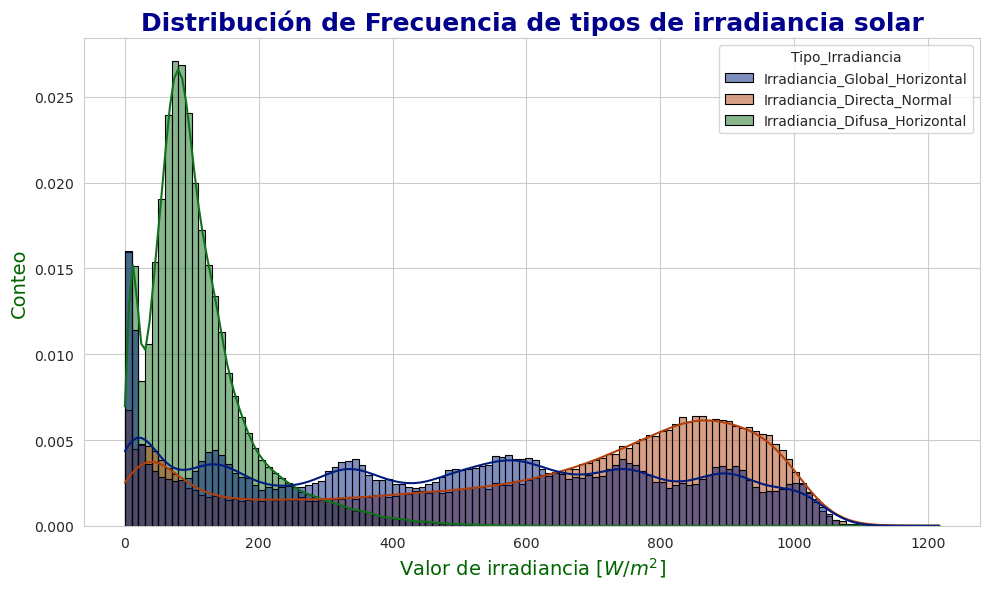

In [ ]:
sns.set_style("whitegrid") 
plt.figure(figsize=(10, 6)) 

sns.histplot(
    data=df_derretido,
    x='Valor_Irradiancia',  
    hue='Tipo_Irradiancia', 
    binwidth=10,            
    kde=True,               
    palette='dark',         
    alpha=0.5,              
    linewidth=0.8,          
    edgecolor='black',      
    stat='probability',     
    common_bins=True,           
)

plt.title('Distribución de Frecuencia de tipos de irradiancia solar', fontsize=18, fontweight='bold', color='darkblue')
plt.xlabel('Valor de irradiancia [$W/m^2$]', fontsize=14, color='darkgreen')
plt.ylabel('Conteo', fontsize=14, color='darkgreen') # Si usas stat='count'

plt.xticks(fontsize=10) 
plt.yticks(fontsize=10)

plt.tight_layout() 
plt.show()

# Funciones de probabilidad

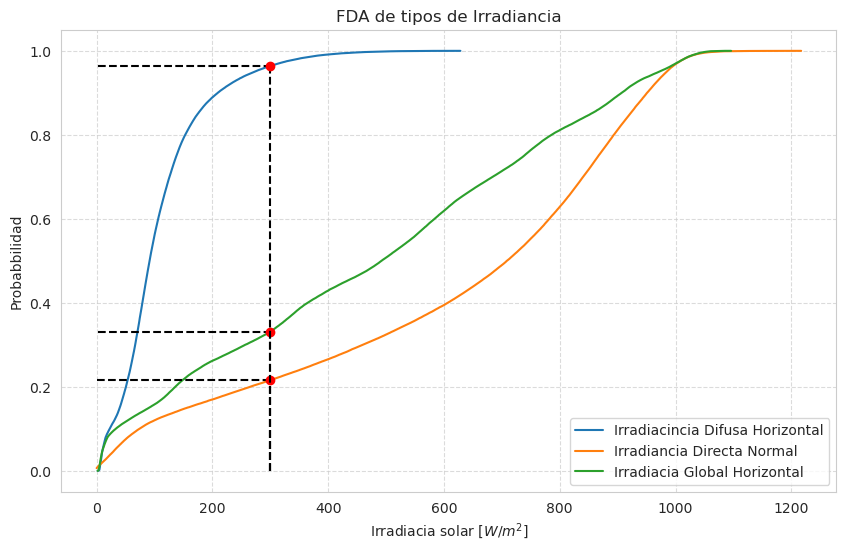

In [57]:
pmf_IGH = empiricaldist.Pmf.from_seq(df_analisis_2.Irradiancia_Global_Horizontal, normalize=True)
cdf_IGH = empiricaldist.Cdf.from_seq(df_analisis_2.Irradiancia_Global_Horizontal, normalize = True)

pmf_IDN = empiricaldist.Pmf.from_seq(df_analisis_2.Irradiancia_Directa_Normal, normalize=True)
cdf_IDN = empiricaldist.Cdf.from_seq(df_analisis_2.Irradiancia_Directa_Normal, normalize = True)

pmf_IDH = empiricaldist.Pmf.from_seq(df_analisis_2.Irradiancia_Difusa_Horizontal, normalize=True)
cdf_IDH = empiricaldist.Cdf.from_seq(df_analisis_2.Irradiancia_Difusa_Horizontal, normalize = True)


q1 = 300
p1 = cdf_IGH.forward(q1)

q2 = 300
p2 = cdf_IDN.forward(q2)

q3 = 300
p3 = cdf_IDH.forward(q2)

plt.figure(figsize=(10,6))

cdf_IDH.plot(label = 'Irradiacincia Difusa Horizontal')
cdf_IDN.plot(label = 'Irradiancia Directa Normal')
cdf_IGH.plot(label = 'Irradiacia Global Horizontal')

plt.vlines(x = q1, ymin = 0, ymax = p1, color = 'black', linestyles = '--')
plt.hlines(y = p1, xmin = pmf_IGH.qs[0], xmax = q1, color = 'black', linestyles='--')
plt.plot(q1, p1, 'ro')

plt.vlines(x = q2, ymin = 0, ymax = p2, color = 'black', linestyles = '--')
plt.hlines(y = p2, xmin = pmf_IDN.qs[0], xmax = q2, color = 'black', linestyles = '--')
plt.plot(q2, p2, 'ro')

plt.vlines(x = q3, ymin = 0, ymax = p3, linestyles = '--', color = 'black')
plt.hlines(y = p3, xmin = pmf_IDH.qs[0], xmax = q3, color = 'black', linestyles = '--')
plt.plot(q3, p3, 'ro')

plt.xlabel('Irradiacia solar [$W/m^2$]')
plt.ylabel('Probabbilidad')
plt.title('FDA de tipos de Irradiancia')
plt.grid(True, linestyle = '--', alpha = 0.7)
plt.legend()

plt.show ()

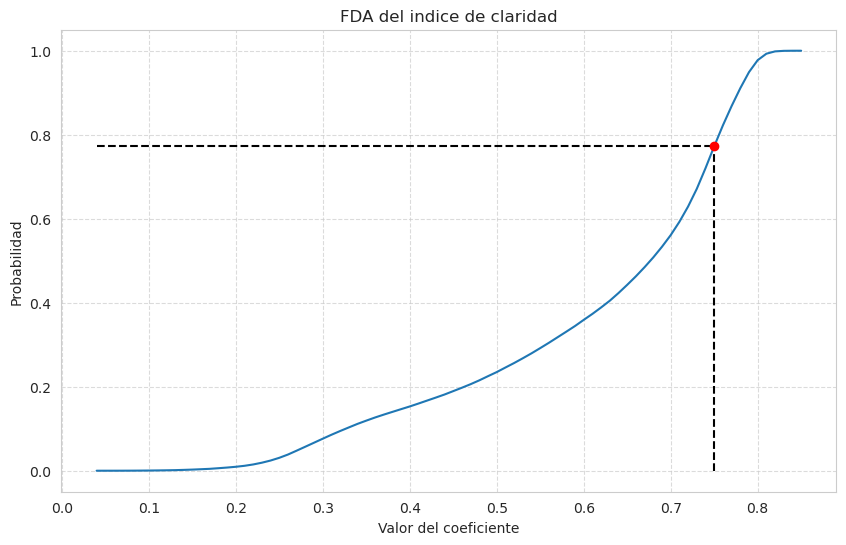

In [58]:
pmf_IC = empiricaldist.Pmf.from_seq(df_analisis_2.Indice_Claridad, normalize=True)
cdf_IC = empiricaldist.Cdf.from_seq(df_analisis_2.Indice_Claridad, normalize=True)

q4 = 0.75
p4 = cdf_IC.forward(q4)

plt.figure(figsize=(10,6))

cdf_IC.plot(label='Indice de Claridad')

plt.vlines(x = q4, ymin = 0, ymax = p4, colors = 'black', linestyles  = '--')
plt.hlines(y = p4, xmin = pmf_IC.qs[0], xmax = q4, colors  = 'black',  linestyle = '--')
plt.plot(q4, p4, 'ro')

plt.xlabel('Valor del coeficiente')
plt.ylabel('Probabilidad')
plt.title('FDA del indice de claridad')
plt.grid(True, linestyle = '--', alpha = 0.7)

plt.show()

<Axes: xlabel='Irradiancia_Global_Horizontal'>

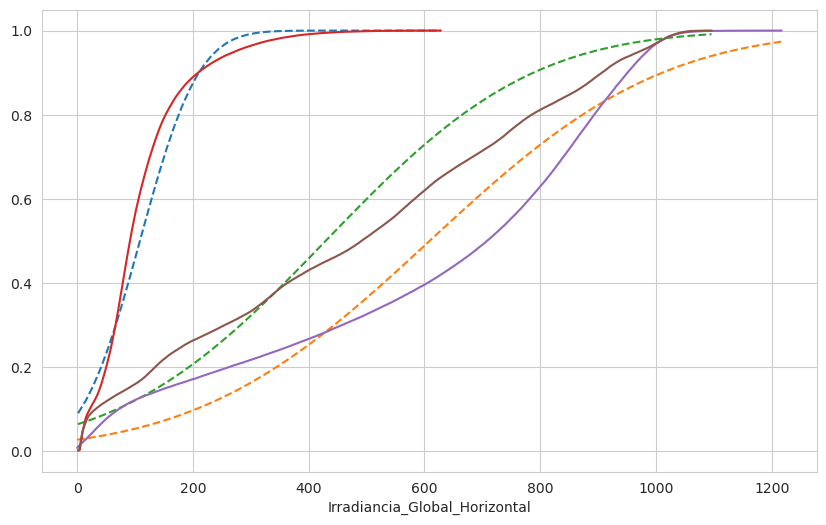

In [59]:
stats1 = df_analisis_2.Irradiancia_Difusa_Horizontal.describe()
stats2 = df_analisis_2.Irradiancia_Directa_Normal.describe()
stats3 = df_analisis_2.Irradiancia_Global_Horizontal.describe()


cdf_IGH = empiricaldist.Cdf.from_seq(df_analisis_2.Irradiancia_Global_Horizontal, normalize = True)
cdf_IDN = empiricaldist.Cdf.from_seq(df_analisis_2.Irradiancia_Directa_Normal, normalize = True)
cdf_IDH = empiricaldist.Cdf.from_seq(df_analisis_2.Irradiancia_Difusa_Horizontal, normalize = True)

xs1 = np.linspace(stats1['min'], stats1['max'])
xs2 = np.linspace(stats2['min'], stats2['max'])
xs3 = np.linspace(stats3['min'], stats3['max'])


ys1 = scipy.stats.norm(stats1['mean'],stats1['std']).cdf(xs1)
ys2 = scipy.stats.norm(stats2['mean'],stats2['std']).cdf(xs2)
ys3 = scipy.stats.norm(stats3['mean'],stats3['std']).cdf(xs2)

plt.figure(figsize=(10,6))
plt.plot(xs1, ys1, linestyle = '--')
plt.plot(xs2, ys2, linestyle = '--')
plt.plot(xs3, ys3, linestyle = '--')

cdf_IDH.plot(label = 'Irradiacincia Difusa Horizontal')
cdf_IDN.plot(label = 'Irradiancia Directa Normal')
cdf_IGH.plot(label = 'Irradiacia Global Horizontal')

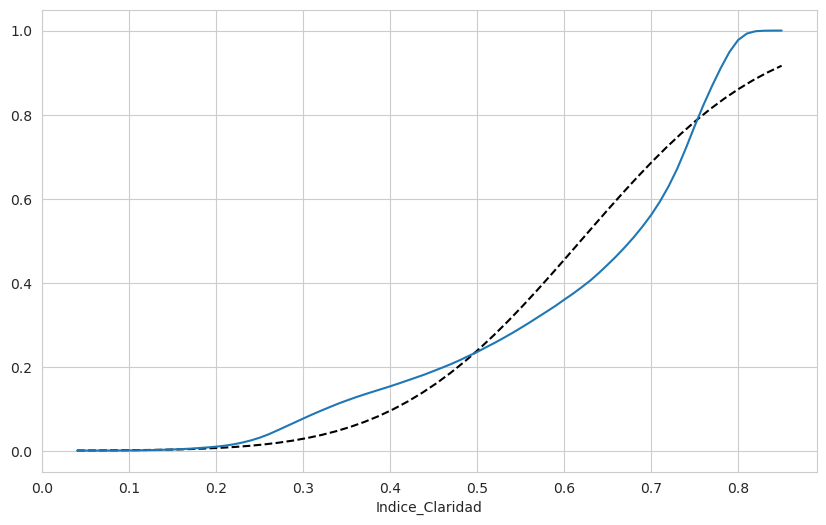

In [60]:
cdf_IC = empiricaldist.Cdf.from_seq(df_analisis_2.Indice_Claridad, normalize=True)
stats4 = df_analisis_2.Indice_Claridad.describe()
xs4 = np.linspace(stats4['min'], stats4['max'])
ys4 = scipy.stats.norm(stats4['mean'],stats4['std']).cdf(xs4)

plt.figure(figsize=(10,6))
plt.plot(xs4,ys4, linestyle = '--', color = 'black')
cdf_IC.plot()

plt.show()

# Visualización Exploratoria

## Gráficos de Línea de la Serie Completa
Grafica la irradiancia a lo largo de todo el período para ver tendencias generales y estacionalidad anual.

In [61]:
if 'FECHA_HORA_LOCAL' in df_analisis_2.columns:
    df_analisis_2 = df_analisis_2.set_index('FECHA_HORA_LOCAL')

# Confirmar que el índice es un DatetimeIndex
if not isinstance(df_analisis_2.index, pd.DatetimeIndex):
    df_analisis_2.index = pd.to_datetime(df_analisis_2.index)

print("Primeras 5 filas de df_analisis_2 con FECHA_HORA_LOCAL como índice:")
print(df_analisis_2.head())
print("\nInformación del DataFrame df_analisis_2 después de la preparación:")
df_analisis_2.info()

# Verificando la cantidad de filas en el primer segmento (2001-2008)
num_filas_1 = len(df_analisis_2.loc['2001-01-01':'2008-12-31'])
print(f"Número de filas en el segmento 2001-2008: {num_filas_1}")

# Verificando la cantidad de filas en el segundo segmento (2009-2016)
num_filas_2 = len(df_analisis_2.loc['2009-01-01':'2016-12-31'])
print(f"Número de filas en el segmento 2009-2016: {num_filas_2}")

# Verificando la cantidad de filas en el tercer segmento (2017-2025)
num_filas_3 = len(df_analisis_2.loc['2017-01-01':'2025-03-31'])
print(f"Número de filas en el segmento 2017-2025: {num_filas_3}")

Primeras 5 filas de df_analisis_2 con FECHA_HORA_LOCAL como índice:
                     Irradiancia_Global_Horizontal  \
FECHA_HORA_LOCAL                                     
2000-12-31 18:00:00                          13.93   
2001-01-01 08:00:00                           4.07   
2001-01-01 09:00:00                          73.18   
2001-01-01 10:00:00                         201.23   
2001-01-01 11:00:00                         336.95   

                     Irradiancia_Directa_Normal  \
FECHA_HORA_LOCAL                                  
2000-12-31 18:00:00                       27.87   
2001-01-01 08:00:00                       11.70   
2001-01-01 09:00:00                       64.20   
2001-01-01 10:00:00                      115.51   
2001-01-01 11:00:00                      142.04   

                     Irradiancia_Difusa_Horizontal  Indice_Claridad  \
FECHA_HORA_LOCAL                                                      
2000-12-31 18:00:00                          16.32   

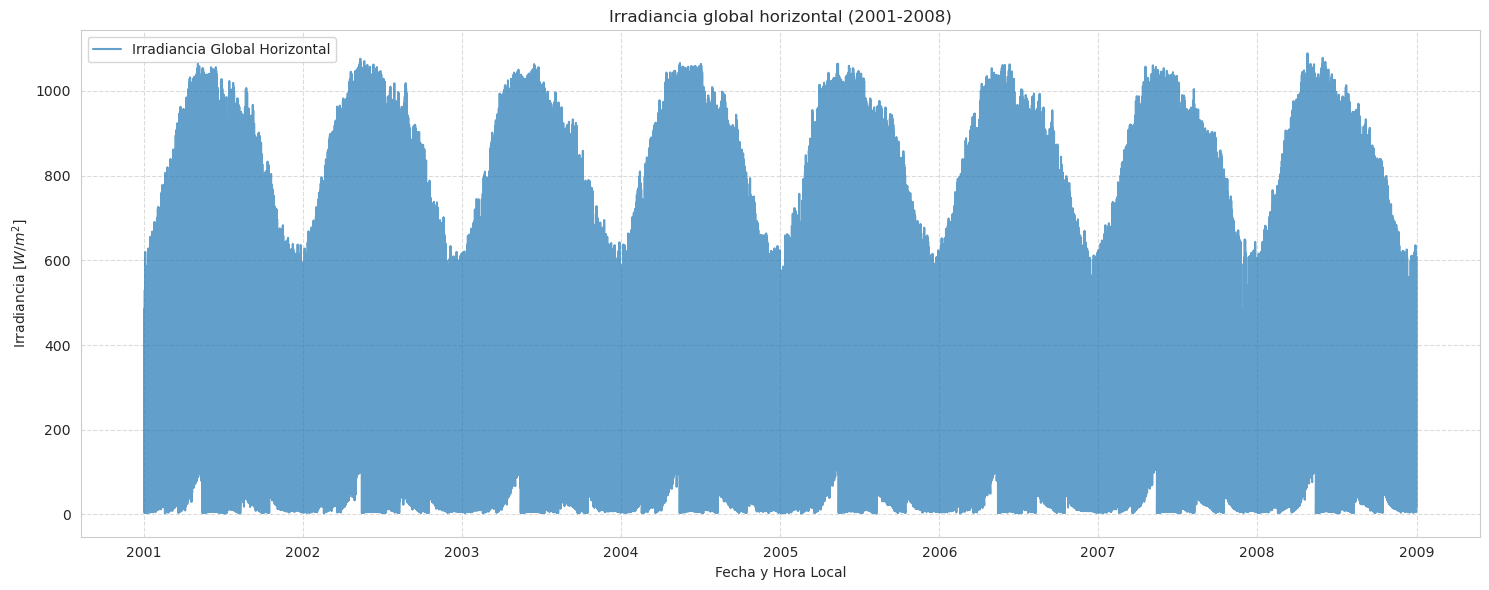

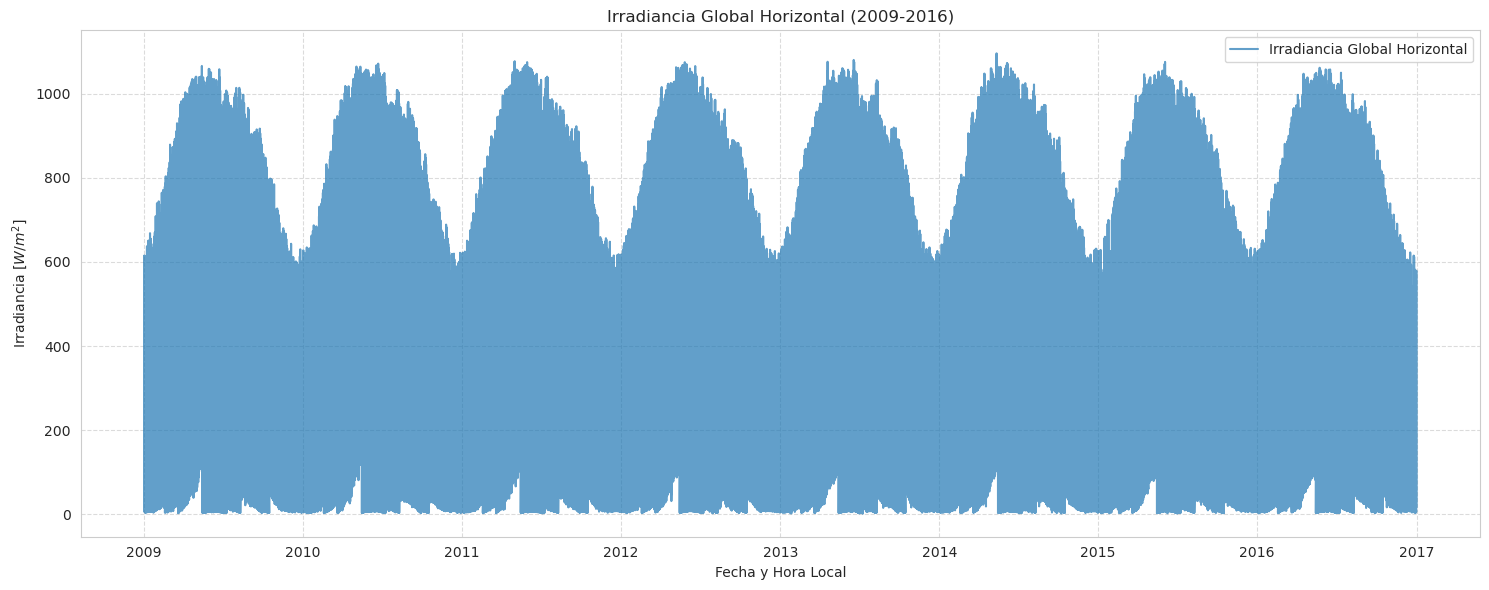

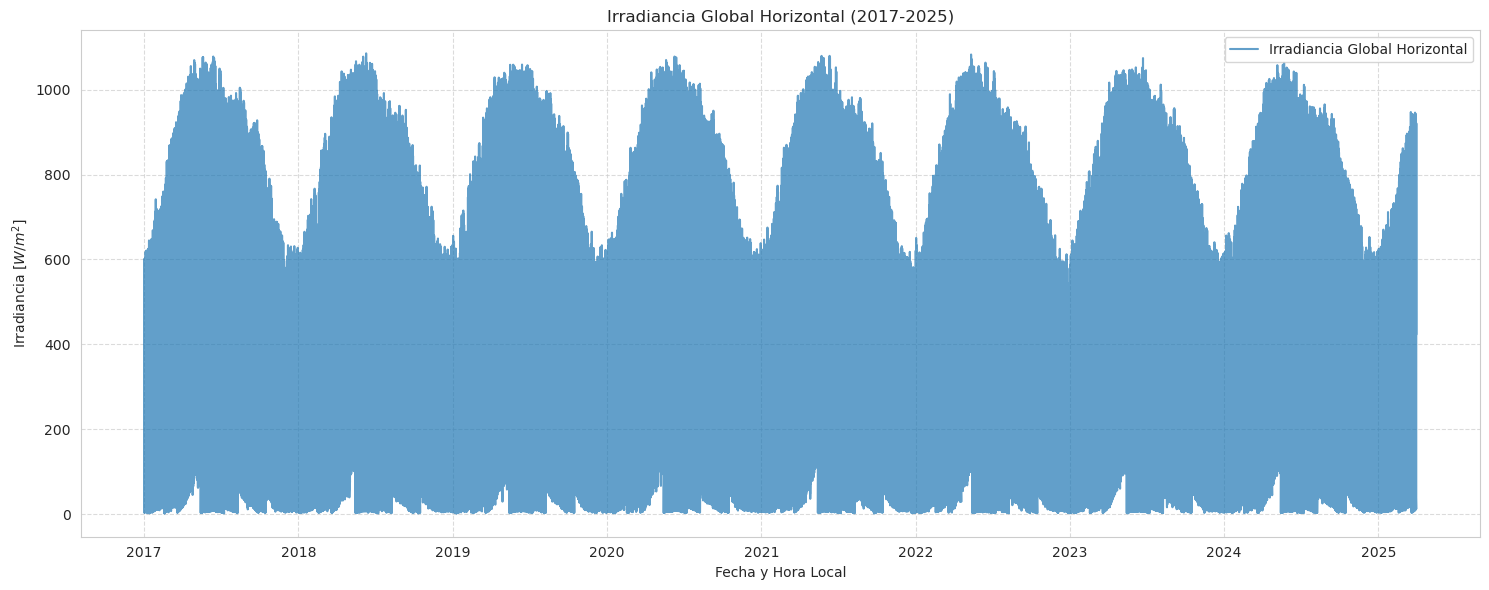

In [62]:
plt.figure(figsize=(15, 6))

plt.plot(df_analisis_2.loc['2001-01-01':'2008-12-31'].index,
         df_analisis_2.loc['2001-01-01':'2008-12-31']['Irradiancia_Global_Horizontal'],
         label='Irradiancia Global Horizontal',
         alpha=0.7)

plt.title('Irradiancia global horizontal (2001-2008)')
plt.xlabel('Fecha y Hora Local')
plt.ylabel('Irradiancia [$W/m^2$]')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(df_analisis_2.loc['2009-01-01':'2016-12-31'].index,
         df_analisis_2.loc['2009-01-01':'2016-12-31']['Irradiancia_Global_Horizontal'],
         label='Irradiancia Global Horizontal',
         alpha=0.7)

plt.title('Irradiancia Global Horizontal (2009-2016)')
plt.xlabel('Fecha y Hora Local')
plt.ylabel('Irradiancia [$W/m^2$]')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(df_analisis_2.loc['2017-01-01':'2025-03-31'].index,
         df_analisis_2.loc['2017-01-01':'2025-03-31']['Irradiancia_Global_Horizontal'],
         label='Irradiancia Global Horizontal',
         alpha=0.7)

plt.title('Irradiancia Global Horizontal (2017-2025)')
plt.xlabel('Fecha y Hora Local')
plt.ylabel('Irradiancia [$W/m^2$]')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

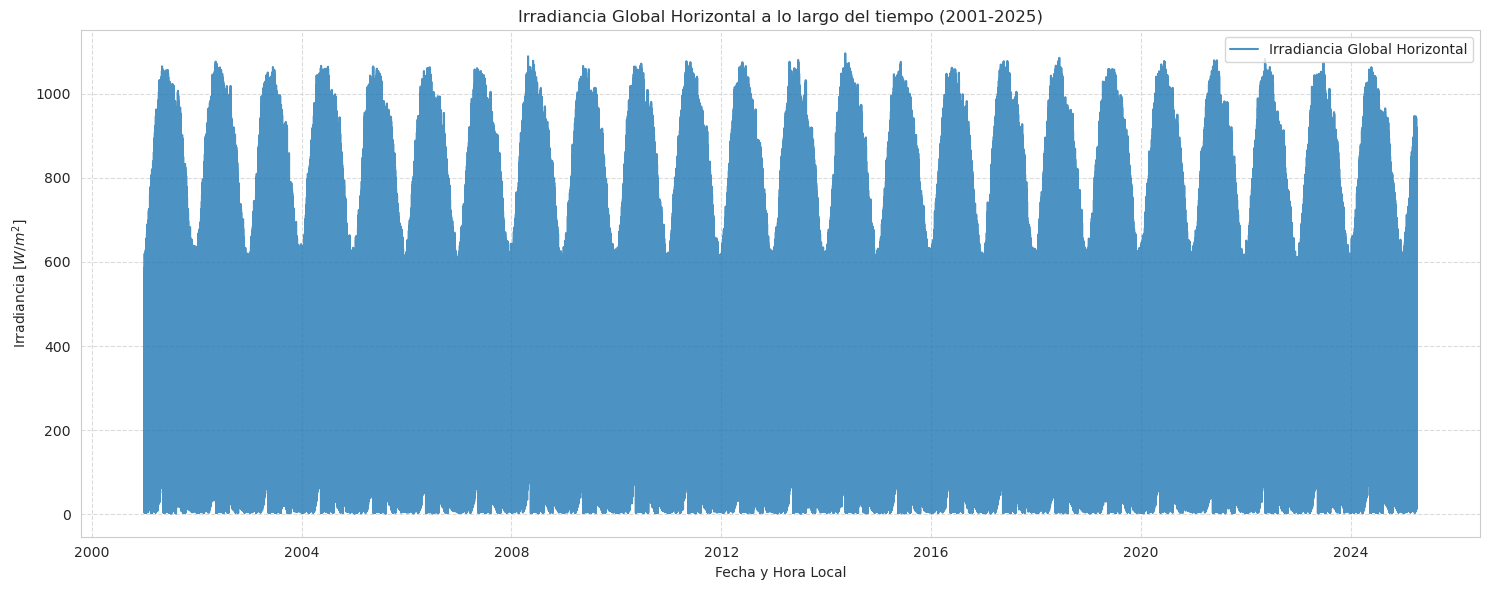

In [63]:

plt.figure(figsize=(15, 6))
plt.plot(df_analisis_2.index, df_analisis_2['Irradiancia_Global_Horizontal'], label='Irradiancia Global Horizontal', alpha=0.8)
plt.title('Irradiancia Global Horizontal a lo largo del tiempo (2001-2025)')
plt.xlabel('Fecha y Hora Local')
plt.ylabel('Irradiancia [$W/m^2$]')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

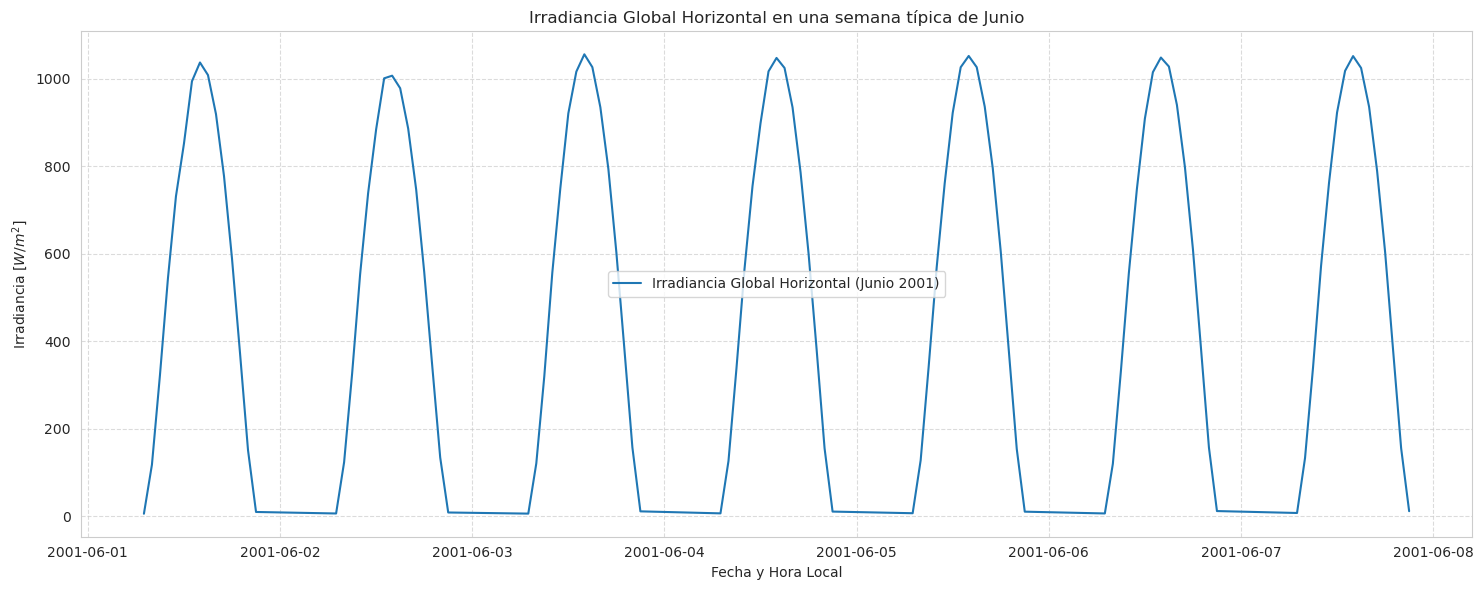

In [64]:

plt.figure(figsize=(15, 6))

plt.plot(df_analisis_2.loc['2001-06-01':'2001-06-07'].index,
         df_analisis_2.loc['2001-06-01':'2001-06-07']['Irradiancia_Global_Horizontal'],
         label='Irradiancia Global Horizontal (Junio 2001)')
plt.title('Irradiancia Global Horizontal en una semana típica de Junio')
plt.xlabel('Fecha y Hora Local')
plt.ylabel('Irradiancia [$W/m^2$]')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Patrón de Irradiancia Promedio por Día del Año
Muestra la estacionalidad anual.

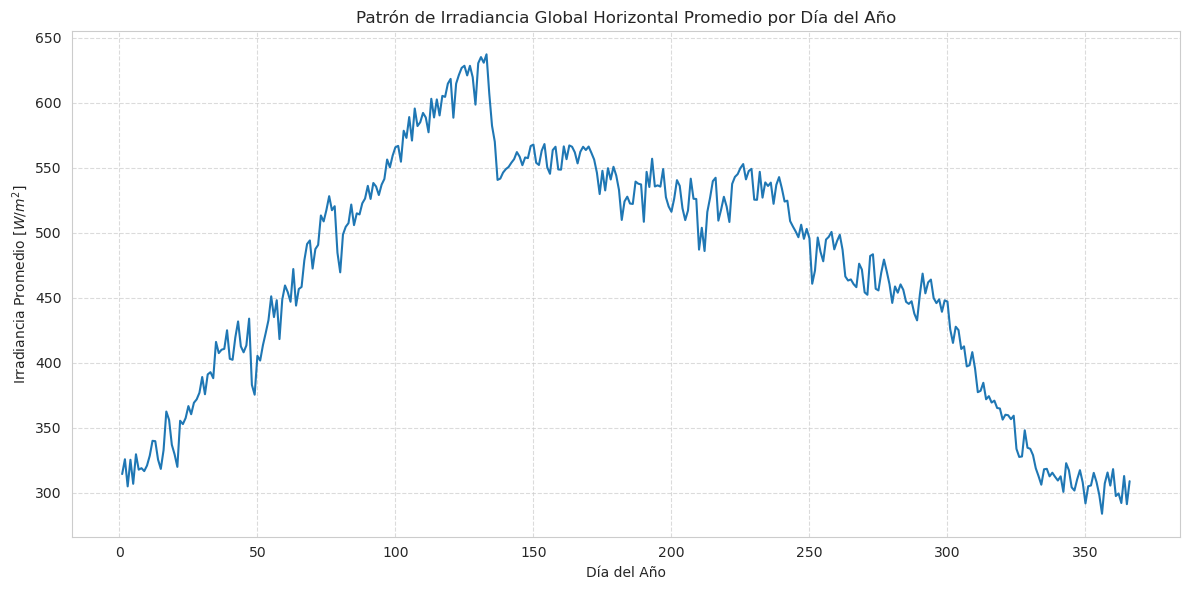

In [65]:
df_analisis_2['Day_of_Year'] = df_analisis_2.index.dayofyear

yearly_average_IGH = df_analisis_2.groupby('Day_of_Year')['Irradiancia_Global_Horizontal'].mean()

plt.figure(figsize=(12, 6))
plt.plot(yearly_average_IGH.index, yearly_average_IGH.values)
plt.title('Patrón de Irradiancia Global Horizontal Promedio por Día del Año')
plt.xlabel('Día del Año')
plt.ylabel('Irradiancia Promedio [$W/m^2$]')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

df_analisis_2.drop('Day_of_Year', axis=1, inplace=True)

# Patrón de Irradiancia Promedio por Hora del Día
Se observa la "curva solar" típica de la ubicación

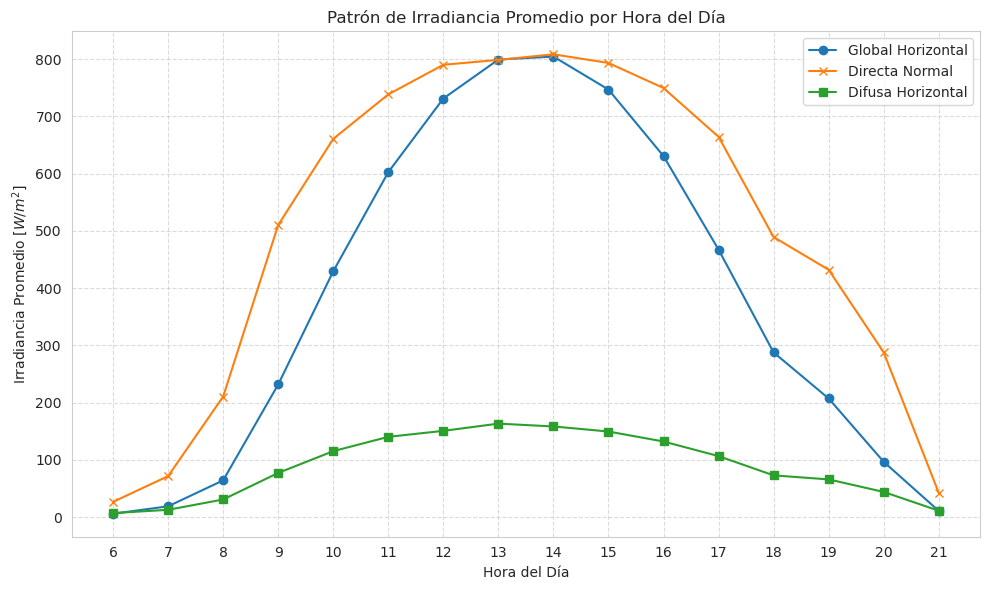

In [66]:
df_analisis_2['Hour_of_Day'] = df_analisis_2.index.hour

daily_average_IGH = df_analisis_2.groupby('Hour_of_Day')['Irradiancia_Global_Horizontal'].mean()
daily_average_IDN = df_analisis_2.groupby('Hour_of_Day')['Irradiancia_Directa_Normal'].mean()
daily_average_IDH = df_analisis_2.groupby('Hour_of_Day')['Irradiancia_Difusa_Horizontal'].mean()

plt.figure(figsize=(10, 6))
plt.plot(daily_average_IGH.index, daily_average_IGH.values, marker='o', label='Global Horizontal')
plt.plot(daily_average_IDN.index, daily_average_IDN.values, marker='x', label='Directa Normal')
plt.plot(daily_average_IDH.index, daily_average_IDH.values, marker='s', label='Difusa Horizontal')

plt.title('Patrón de Irradiancia Promedio por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Irradiancia Promedio [$W/m^2$]')
plt.xticks(daily_average_IGH.index) 
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

df_analisis_2.drop('Hour_of_Day', axis=1, inplace=True)

# Mapa de Calor de Irradiancia Horaria por Mes
Visualización para observar la interacción entre la hora del día y el mes del año.

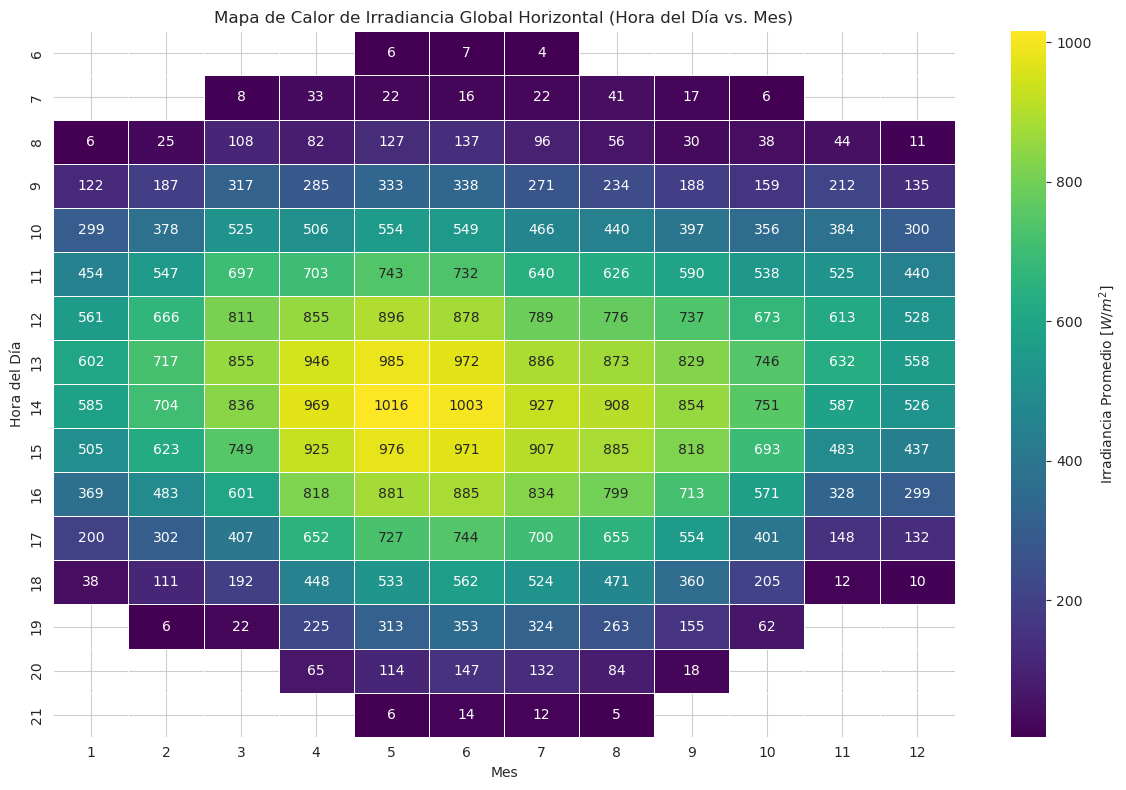

In [67]:
df_analisis_2['Month'] = df_analisis_2.index.month
df_analisis_2['Hour'] = df_analisis_2.index.hour

heatmap_data = df_analisis_2.pivot_table(values='Irradiancia_Global_Horizontal', index='Hour', columns='Month', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt=".0f", linewidths=.5, cbar_kws={'label': 'Irradiancia Promedio [$W/m^2$]'})
plt.title('Mapa de Calor de Irradiancia Global Horizontal (Hora del Día vs. Mes)')
plt.xlabel('Mes')
plt.ylabel('Hora del Día')
plt.tight_layout()
plt.show()

df_analisis_2.drop(['Month', 'Hour'], axis=1, inplace=True)

# Descomposición de Series de Tiempo

La descomposición de la serie en sus componentes: tendencia, estacionalidad y residuos

/tmp/ipykernel_66804/3058497133.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_hourly_series = df_analisis_2['Irradiancia_Global_Horizontal'].resample('H').mean()


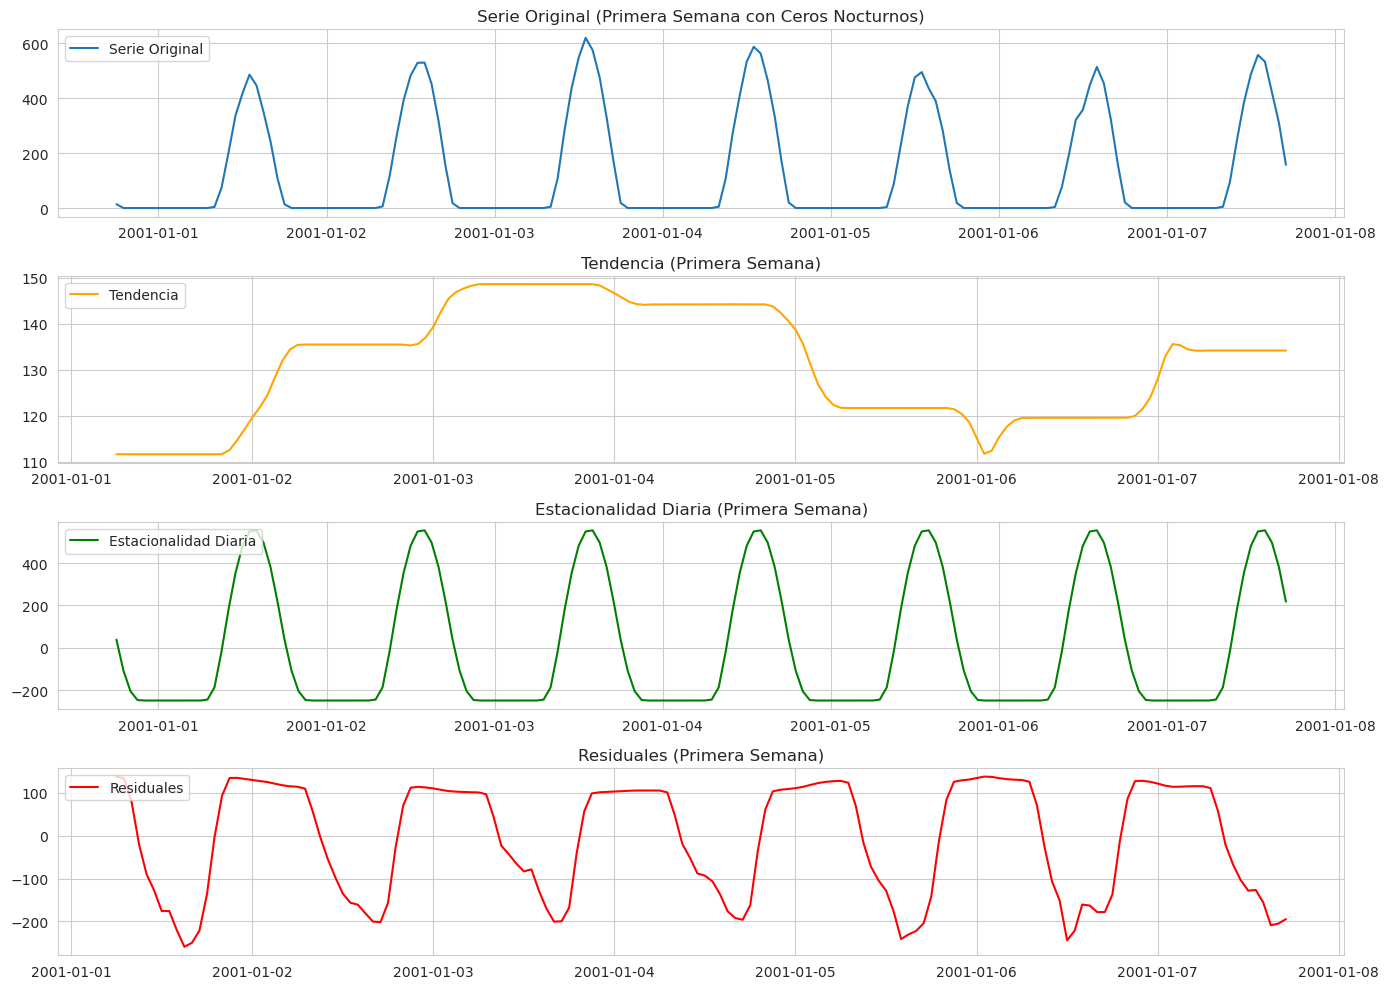

In [68]:
full_hourly_series = df_analisis_2['Irradiancia_Global_Horizontal'].resample('H').mean()
full_hourly_series = full_hourly_series.fillna(0) 
decomposition_daily = seasonal_decompose(full_hourly_series, model='additive', period=24) 

plt.figure(figsize=(14, 10))
num_hours_to_plot = 24 * 7 

plt.subplot(411)
plt.plot(full_hourly_series.index[:num_hours_to_plot], full_hourly_series.values[:num_hours_to_plot], label='Serie Original')
plt.legend(loc='upper left')
plt.title('Serie Original (Primera Semana con Ceros Nocturnos)')

plt.subplot(412)
plt.plot(decomposition_daily.trend.index[:num_hours_to_plot], decomposition_daily.trend.values[:num_hours_to_plot], label='Tendencia', color='orange')
plt.legend(loc='upper left')
plt.title('Tendencia (Primera Semana)')

plt.subplot(413)
plt.plot(decomposition_daily.seasonal.index[:num_hours_to_plot], decomposition_daily.seasonal.values[:num_hours_to_plot], label='Estacionalidad Diaria', color='green')
plt.legend(loc='upper left')
plt.title('Estacionalidad Diaria (Primera Semana)')

plt.subplot(414)
plt.plot(decomposition_daily.resid.index[:num_hours_to_plot], decomposition_daily.resid.values[:num_hours_to_plot], label='Residuales', color='red')
plt.legend(loc='upper left')
plt.title('Residuales (Primera Semana)')

plt.tight_layout()
plt.show()

# Detección de Anomalías
Seidentifican puntos de datos que se desvían significativamente del patrón general.

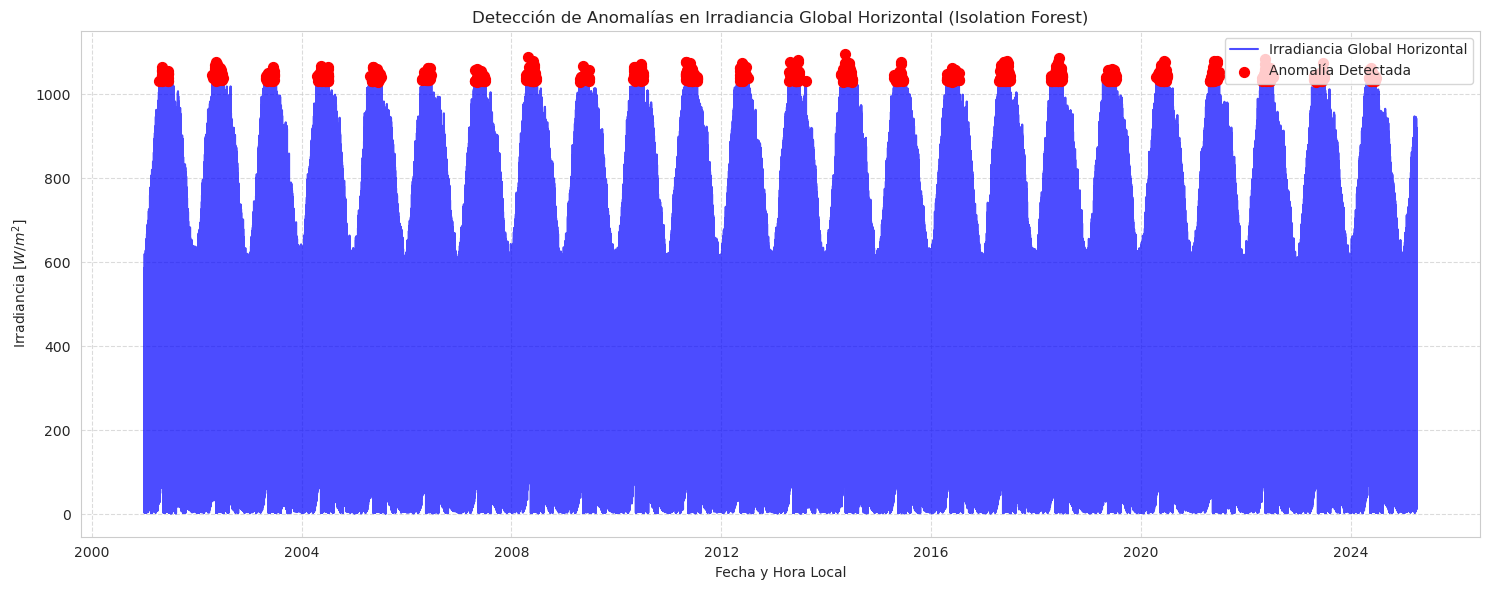


Número total de anomalías detectadas: 1114


In [69]:
data_for_anomaly = df_analisis_2[['Irradiancia_Global_Horizontal']].copy()

iso_forest = IsolationForest(contamination=0.01, random_state=42) 
iso_forest.fit(data_for_anomaly)

data_for_anomaly['anomaly'] = iso_forest.predict(data_for_anomaly)

plt.figure(figsize=(15, 6))
plt.plot(data_for_anomaly.index, data_for_anomaly['Irradiancia_Global_Horizontal'], label='Irradiancia Global Horizontal', color='blue', alpha=0.7)

anomalies = data_for_anomaly[data_for_anomaly['anomaly'] == -1]
plt.scatter(anomalies.index, anomalies['Irradiancia_Global_Horizontal'], color='red', s=50, label='Anomalía Detectada', zorder=5)

plt.title('Detección de Anomalías en Irradiancia Global Horizontal (Isolation Forest)')
plt.xlabel('Fecha y Hora Local')
plt.ylabel('Irradiancia [$W/m^2$]')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nNúmero total de anomalías detectadas: {len(anomalies)}")

# Análisis de Patrones de Irradiancia (Relación entre Variables)
Exploracion de como se relacionan las diferentes mediciones de irradiancia entre sí y con el indice de claridad.

/tmp/ipykernel_66804/3836402106.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/carlos23/anaconda3/envs/Curso_platzi/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


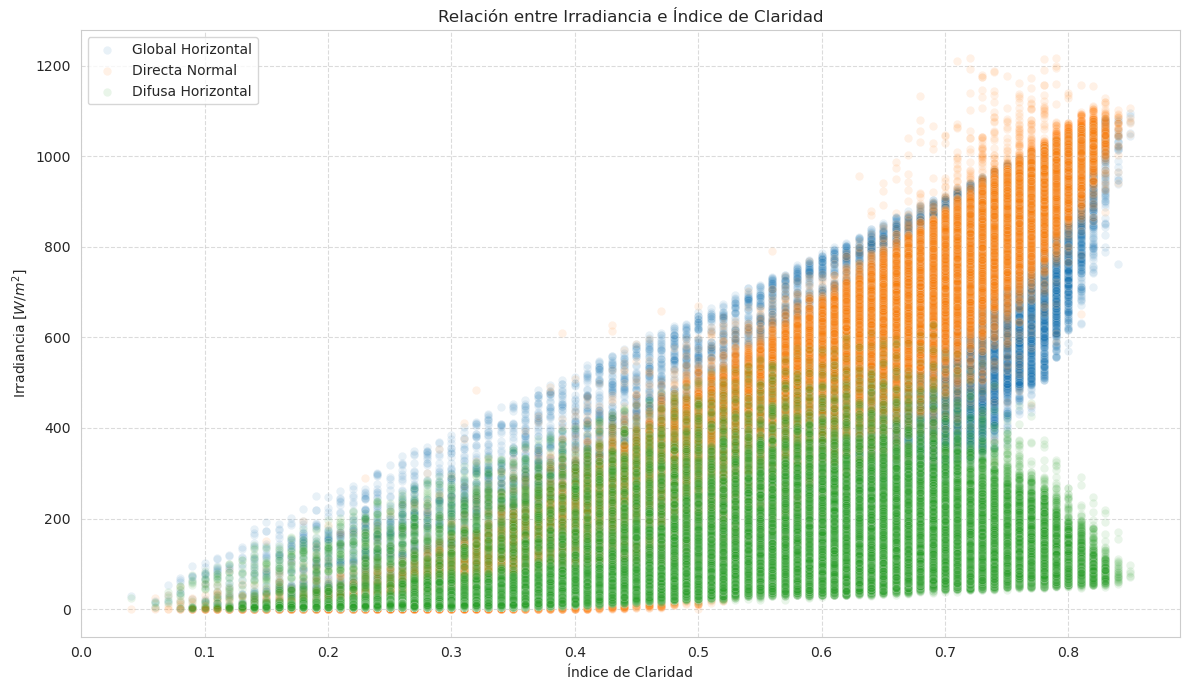

In [70]:
plt.figure(figsize=(12, 7))

sns.scatterplot(x='Indice_Claridad', y='Irradiancia_Global_Horizontal', data=df_analisis_2, alpha=0.1, label='Global Horizontal')
sns.scatterplot(x='Indice_Claridad', y='Irradiancia_Directa_Normal', data=df_analisis_2, alpha=0.1, label='Directa Normal')
sns.scatterplot(x='Indice_Claridad', y='Irradiancia_Difusa_Horizontal', data=df_analisis_2, alpha=0.1, label='Difusa Horizontal')

plt.title('Relación entre Irradiancia e Índice de Claridad')
plt.xlabel('Índice de Claridad')
plt.ylabel('Irradiancia [$W/m^2$]')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

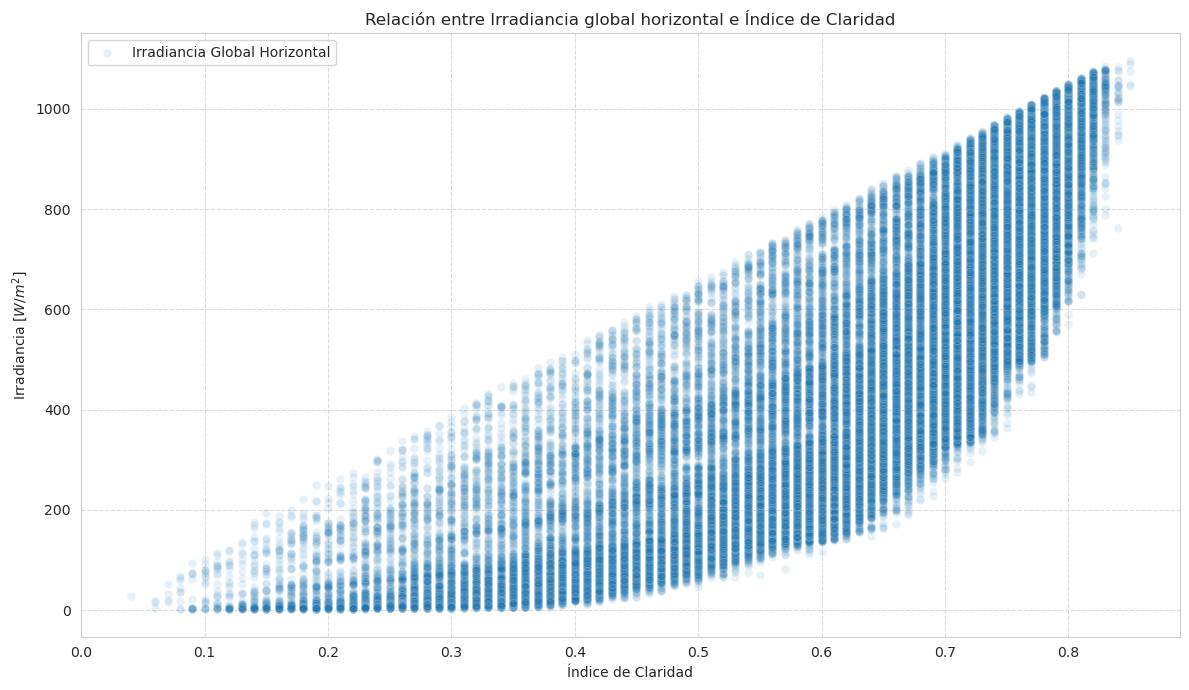

In [71]:
plt.figure(figsize=(12, 7))

sns.scatterplot(x='Indice_Claridad', y='Irradiancia_Global_Horizontal', data=df_analisis_2, alpha=0.1, label='Irradiancia Global Horizontal')

plt.title('Relación entre Irradiancia global horizontal e Índice de Claridad')
plt.xlabel('Índice de Claridad')
plt.ylabel('Irradiancia [$W/m^2$]')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

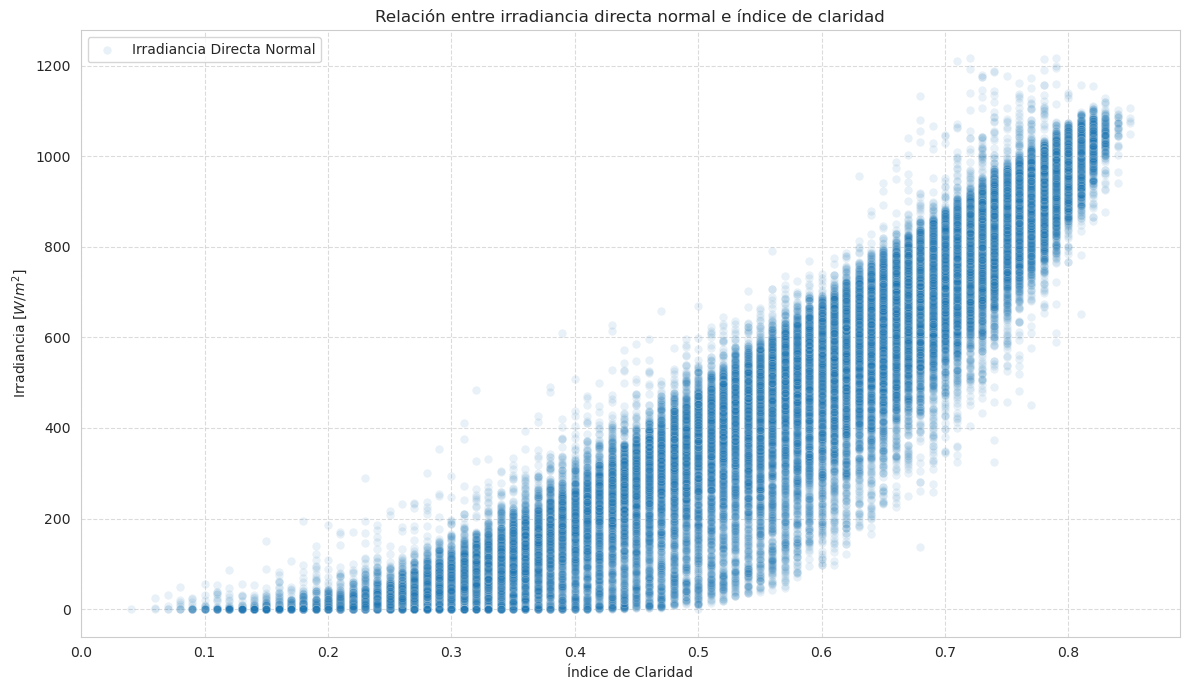

In [72]:
plt.figure(figsize=(12, 7))

sns.scatterplot(x='Indice_Claridad', y='Irradiancia_Directa_Normal', data=df_analisis_2, alpha=0.1, label='Irradiancia Directa Normal')

plt.title('Relación entre irradiancia directa normal e índice de claridad')
plt.xlabel('Índice de Claridad')
plt.ylabel('Irradiancia [$W/m^2$]')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

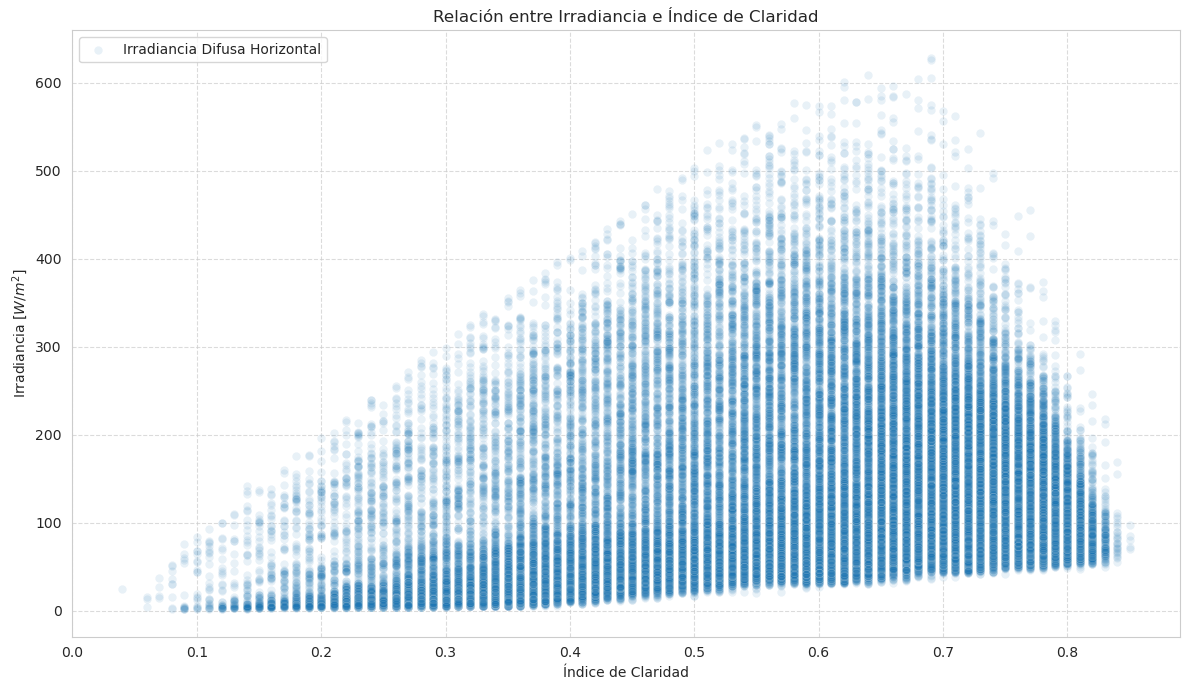

In [73]:
plt.figure(figsize=(12, 7))

sns.scatterplot(x='Indice_Claridad', y='Irradiancia_Difusa_Horizontal', data=df_analisis_2, alpha=0.1, label='Irradiancia Difusa Horizontal')

plt.title('Relación entre Irradiancia e Índice de Claridad')
plt.xlabel('Índice de Claridad')
plt.ylabel('Irradiancia [$W/m^2$]')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()